In [1]:
#
#  Test getting sensitivity of ca vs k1 for A->B
#  Analytical solution:
#    ca = ca0*exp(-k1*t)
#    dca/dk1 = -t*ca0*exp(-k1*t)
#

In [2]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
from kipet.library.EstimabilityAnalyzer import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd

In [3]:
# Generate dummy data
builder = TemplateBuilder()  
    
builder.add_mixture_component('A', 2.0)
builder.add_parameter('k1', 1.0)
    
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    return exprs

builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,10.0)

In [4]:
# simulate to get the data
simulator = PyomoSimulator(opt_model)
simulator.apply_discretization('dae.collocation', ncp = 1, nfe = 60, scheme = 'LAGRANGE-RADAU')
results_pyomo = simulator.run_sim('ipopt',tee=True)

Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:      301
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      121
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      121
Total number of inequali

In [5]:
# add noise
C_data = results_pyomo.Z
C_data['A'] = C_data['A'] + np.random.normal(0, 0.1, results_pyomo.Z.shape[0])

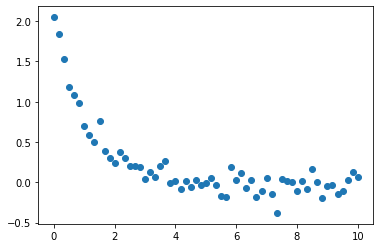

In [6]:
fig, ax = plt.subplots()
ax.scatter(C_data.index, C_data['A'])

In [13]:
builder = TemplateBuilder()  
    
builder.add_mixture_component('A', 2.0)

builder.add_parameter('k1', init = 1.0, bounds = (0.1, 10))
#builder.add_parameter('k1', bounds = (0.1, 10))

def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    return exprs

builder.add_concentration_data(C_data)
builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,10.0)
# I need to put this here instead to make it work instead of
# builder.add_parameter('k1', 1, bounds = (0.1, 10))
#opt_model.P['k1'].value = 1.0

Warning! Since C-matrix contains negative values Kipet is assuming a derivative of C has been inputted


In [14]:
e_analyzer = EstimabilityAnalyzer(opt_model)
e_analyzer.apply_discretization('dae.collocation', nfe = 100, ncp = 2, scheme = 'LAGRANGE-RADAU')

In [15]:
sigmas = {'A': 1}
dsdp, idx_to_param = e_analyzer.get_sensitivities_for_params(tee=True, sigmasq=sigmas)

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]This problem has no degrees of freedom
Pass the option square_override for the desired behaviour
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zL_out suffix declared, setting zL = 0.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dsdp_in_.in
W[K_AUG]...	[K_AUG_ASL]dsdp for linear C(x) + I*p = 0 override.


[K_AUG] written by D.T. @2018

: dsdp_mode=
dsdp_mode=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 402
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 402
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 0
I[K_AUG]...	[ADJUST_MU]	Warning no relevant info from the problem can predict logmu
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 402, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 1402
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 261
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.778586
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 341
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG]...	[ASSM_RHS_DCDP]According to the suffixes declare

In [16]:
tlist = np.array(e_analyzer.model.allmeas_times)
dca_dk1 = dsdp.copy()
dca_dk1_act = -tlist * 2 * np.exp(-tlist) # sensitivity dca/dk1 = -t*ca0*exp(-k1*t)

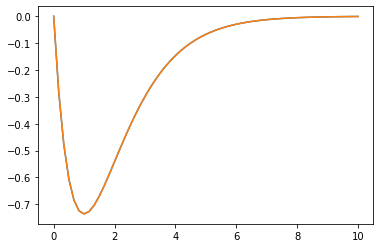

In [17]:
fig, ax = plt.subplots()
ax.plot(tlist, dca_dk1)
ax.plot(tlist, dca_dk1_act)